In [1]:
#import data
import pandas as pd
import pyrsm as rsm
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
interaction = pd.read_csv('data/RAW_interactions.csv')
recipe = pd.read_csv("data/RAW_recipes.csv")

In [11]:
# drop rows with na
interaction = interaction.dropna()

# reset_index since we dropped some rows
interaction = interaction.reset_index()

# drop unneeded col
interaction = interaction.drop(columns=["index"])

# take first 100 rows for example
interaction_tmp = interaction.loc[0:99, :]

interaction_tmp

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
95,456221,208980,2010-02-20,5,"This is a favorite here, too-- have made it se..."
96,229619,208980,2011-06-26,5,I was flipping through one of Rachael Ray's co...
97,280271,219118,2008-11-09,4,This is so yummy. Quick to prepare and can sim...
98,305531,219118,2008-12-17,4,Really good carrots! There were a great side d...


In [2]:
# groupby recipe_id
interaction_groupby = interaction.groupby(by=["recipe_id"])["review"].count().sort_values(ascending=False)

# transform groupbyed result to dataframe
tmp = interaction_groupby.to_frame()
tmp = tmp.rename(columns={"review": "review_count"})

# see how many recipes are there
len(tmp.query("review_count > 80")) # 1067

# if > 80, assgin 1 in the selected col
tmp["selected"] = rsm.ifelse(tmp.review_count > 80, 1, 0)

# reset_index
tmp = tmp.reset_index()

# merge
interaction_merge = interaction.merge(tmp, on="recipe_id", how="left") # left_join
interaction_merge

# get selected data only
interaction_selected = interaction_merge.query("selected == 1")
interaction_selected

# reset_index
interaction_selected = interaction_selected.reset_index()

# drop unneeded col
interaction_selected = interaction_selected.drop(columns=["index"])
interaction_selected


,user_id,recipe_id,date,rating,review,review_count,selected
0,2002084345,9054,2018-03-30,1,Mush,108,1
1,107135,135585,2006-04-02,5,i love buffulo wings and this makes it easy,103,1
2,53932,135585,2006-04-10,5,This is a lower calorie and neater way to enjo...,103,1
3,33159,135585,2006-04-23,5,Very satisfying & flavourful way to do chicken...,103,1
4,60260,135585,2006-04-26,5,Everyone loved this chicken! I used Frank's Ho...,103,1
...,...,...,...,...,...,...,...
189682,2001388634,38966,2017-02-12,1,NASTY,171,1
189683,2001452240,38966,2017-04-17,1,Question: I made this and I could taste the ba...,171,1
189684,2002038461,38966,2018-04-01,5,"Made this tonight, it’s so buttery and vanilla...",171,1
189685,2002134886,38966,2018-04-29,5,"My toddler loves to bake, and this recipe was ...",171,1


In [3]:
# model to preprocessing reviews
import nltk
nltk.download('punkt') # downloads you a model                                                                                                         

nltk.download('stopwords') 
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# print(stop)

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer 

ps = PorterStemmer() 

# return a list of tokens
def pre_processing_by_nltk(doc, stemming = True, need_sent = False):
    # step 1: get sentences
    sentences = sent_tokenize(doc)
    # step 2: get tokens
    tokens = []
    for sent in sentences:
        words = word_tokenize(sent)
        # step 3 (optional): stemming
        if stemming:
            words = [ps.stem(word) for word in words]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
    return [w.lower() for w in tokens if w.isalpha()]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wufan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wufan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#apply on all data


review_split_100 = interaction_selected.iloc[:100].review.apply(pre_processing_by_nltk)
review_split_100

0                                                [mush]
1     [i, love, buffulo, wing, and, thi, make, it, e...
2     [thi, is, a, lower, calori, and, neater, way, ...
3     [veri, satisfi, flavour, way, to, do, chicken,...
4     [everyon, love, thi, chicken, i, use, frank, h...
                            ...                        
95    [so, i, made, thi, and, total, misread, the, i...
96    [we, didn, t, even, bake, them, and, they, tur...
97    [thi, wa, delici, i, eat, low, carb, high, fat...
98    [i, ve, made, thi, quit, a, few, time, now, an...
99    [i, tri, thi, today, minu, the, celeri, seed, ...
Name: review, Length: 100, dtype: object

In [13]:
#read two txt to recognize pos or neg words

pos_words = open("positive-words.txt").read().split('\n')
neg_words = open("negative-words.txt").read().split('\n')

In [14]:
#function to calculate percentages
def percentage_PN(re):
    
    #calculate positive word
    numPosWords = 0
    for word in re:
        if word in pos_words:
            numPosWords += 1
    
    # calculate negative words    
    numNegWords = 0   
    for word in re:
        if word in neg_words:
            numNegWords += 1
    
    #decide if positiv eor negative
    if numPosWords > numNegWords:
        return("Positive")
    elif numNegWords > numPosWords:
        return("Negative")
    elif numNegWords == numPosWords:
        return("Neutral")  

In [16]:
# apply on whole data

per_results = review_split_100.apply(percentage_PN)

In [17]:
#combine percentage results with recipe id

d = {'recipe_id':interaction.recipe_id ,'per_results':per_results}
df_per = pd.DataFrame(data = d)
df_per = df_per.dropna()
df_per

,recipe_id,per_results
0,40893,Neutral
1,40893,Positive
2,44394,Positive
3,85009,Positive
4,85009,Positive
...,...,...
95,208980,Neutral
96,208980,Positive
97,219118,Positive
98,219118,Positive


In [19]:
#add label into dataframe

df_per.loc[:,'label'] = 0

In [20]:
#change positve, negative, neutral to 2,1,0
num_df_per = df_per

num_df_per["label"][num_df_per.per_results == "Positive"] = 2
num_df_per["label"][num_df_per.per_results == "Neutral"] = 1
num_df_per["label"][num_df_per.per_results == "Negative"] = 0
num_df_per

,recipe_id,per_results,label
0,40893,Neutral,1
1,40893,Positive,2
2,44394,Positive,2
3,85009,Positive,2
4,85009,Positive,2
...,...,...,...
189628,389472,Neutral,1
189629,402003,Positive,2
189630,402003,Positive,2
189631,402003,Positive,2


In [21]:
# combine num_df_per with recipe to get final dataset
num_df_per = num_df_per.rename(columns={"recipe_id": "id"})

# final dataset
DF = num_df_per.merge(recipe, on="id", how="left") # left_join
DF

,id,per_results,label,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,40893,Neutral,1,white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
1,40893,Positive,2,white bean green chile pepper soup,495,1533,2002-09-21,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
2,44394,Positive,2,devilicious cookie cake delights,20,56824,2002-10-27,"['30-minutes-or-less', 'time-to-make', 'course...","[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]",5,"['blend together cake mix , oil and eggs', 'ad...",NaN,"[""devil's food cake mix"", 'vegetable oil', 'eg...",4
3,85009,Positive,2,baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13
4,85009,Positive,2,baked potato toppings,10,64342,2004-02-25,"['15-minutes-or-less', 'time-to-make', 'course...","[2786.2, 342.0, 134.0, 290.0, 161.0, 301.0, 42.0]",3,['pick whichever topping you want to use and c...,these toppings sure makes a nice change from p...,"['mayonnaise', 'salsa', 'cheddar cheese', 'ref...",13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189628,389472,Neutral,1,chunky italian sausage stew cook once eat tw...,325,233583,2009-09-09,"['weeknight', 'course', 'preparation', 'occasi...","[902.0, 104.0, 39.0, 141.0, 92.0, 115.0, 9.0]",9,['in a very large skillet cook the bulk sausag...,"""after a long day sit down with a steaming bow...","['italian sausage', 'pepperoni', 'yellow sweet...",8
189629,402003,Positive,2,mexican meltdown,15,37449,2009-12-01,"['weeknight', '15-minutes-or-less', 'time-to-m...","[315.9, 42.0, 4.0, 30.0, 28.0, 65.0, 0.0]",12,"['heat olive oil in a skillet', 'saute onion ,...","thick bread slices filled with onion, red and...","['bread', 'extra virgin olive oil', 'green bel...",10
189630,402003,Positive,2,mexican meltdown,15,37449,2009-12-01,"['weeknight', '15-minutes-or-less', 'time-to-m...","[315.9, 42.0, 4.0, 30.0, 28.0, 65.0, 0.0]",12,"['heat olive oil in a skillet', 'saute onion ,...","thick bread slices filled with onion, red and...","['bread', 'extra virgin olive oil', 'green bel...",10
189631,402003,Positive,2,mexican meltdown,15,37449,2009-12-01,"['weeknight', '15-minutes-or-less', 'time-to-m...","[315.9, 42.0, 4.0, 30.0, 28.0, 65.0, 0.0]",12,"['heat olive oil in a skillet', 'saute onion ,...","thick bread slices filled with onion, red and...","['bread', 'extra virgin olive oil', 'green bel...",10


In [23]:
# save DF to csv and export
DF.to_csv('recipeReviews.csv')

## Models

In [192]:
# specify X and y
X, y = DF.loc[:, ["minutes", "n_steps", "n_ingredients"]], DF["label"]

In [193]:
from sklearn.model_selection import train_test_split

# splitting the train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2, shuffle=False)

print(len(X_train), len(X_test))

151706 37927


## Neural Network model

In [146]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics

In [126]:
# Neural net from SKLEARN
#clf = MLPClassifier(
#    activation="tanh",
#    solver="lbfgs",
#   alpha=0.01,
#    hidden_layer_sizes=(1,),
#    random_state=1234,
#    max_iter=10000,
#).fit(X_train, y_train)

# CV for NN 
#nr_hnodes = range(1, 5)
#hls = list(zip(nr_hnodes)) + list(zip(nr_hnodes, nr_hnodes))
#hls
# alpha is the level of regularization
#param_grid = {"hidden_layer_sizes": hls, "alpha": [0.001, 0.01, 0.05]}
#scoring = {"AUC": "roc_auc"}

#clf_cv = GridSearchCV(
    #clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
#)
#clf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', alpha=0.01,
                                     hidden_layer_sizes=(1,), max_iter=10000,
                                     random_state=1234, solver='lbfgs'),
             n_jobs=4,
             param_grid={'alpha': [0.001, 0.01, 0.05],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (1, 1),
                                                (2, 2), (3, 3), (4, 4)]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [189]:
# final model
clf_cv = MLPClassifier(
    activation="tanh",
    solver="lbfgs",
    alpha=0.01,
    hidden_layer_sizes=(4,4),
    random_state=1234,
    max_iter=10000,
).fit(X_train, y_train)

* calculate Accuracy

In [197]:
preds_mlp_test =clf_cv.predict(X_test)

#Accuracy
from sklearn.metrics import accuracy_score

# evaluate predictions
accuracy_mlp = accuracy_score(y_test, preds_mlp_test)
print("Accuracy: %.2f%%" % (accuracy_mlp * 100.0))

Accuracy: 82.06%


## XGBoost model

In [176]:
import xgboost as xgb

In [177]:
# defind the parameter grid: xgb_param_grid
#xgb_param_grid = {
    #'n_estimators': range(100,300,100),
    #'max_depth': range(2,5)
#}

# Instantiate the regressor: gbm
#xgb_clf = xgb.XGBClassifier()

# perform grid search
#xgb_cv = GridSearchCV(
   # xgb_clf, xgb_param_grid,scoring="roc_auc",cv=5,n_jobs=-1, refit="AUC", verbose=1
#).fit(X_train, y_train)

In [180]:
# train the ideal XGBClassifier model and predict test data into it
xgb_clf_good = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=100,
    objective="binary:logistic",
    use_label_encoder=False,
    # early_stopping_rounds=10,
    eval_metric="auc",
    random_state=1234
).fit(X_train, y_train, verbose=True)

preds_prob =xgb_clf_good.predict_proba(X_test)

* calculate Accuracy

In [181]:
preds_xgb_test =xgb_clf_good.predict(X_test)

#Accuracy
from sklearn.metrics import accuracy_score

# evaluate predictions
accuracy_xgb = accuracy_score(y_test, preds_xgb_test)
print("Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

Accuracy: 82.64%


### EXTRA1: positive, negative, neutral words percentage 

In [114]:
#calcualte the pos, neg, neu percentages

per_results_gb = df.groupby('per_results').count().reset_index()
per_results_gb = per_results_gb.rename(columns = {"recipe_id" : "count"})
per_Neg = per_results_gb.iloc[0,1] / sum(per_results_gb.iloc[:,1])
per_Pos = per_results_gb.iloc[2,1] / sum(per_results_gb.iloc[:,1])
per_Neu = per_results_gb.iloc[1,1] / sum(per_results_gb.iloc[:,1])

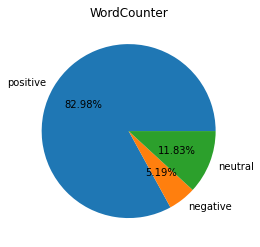

In [115]:
#pie plot to show percentages

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
labels = ['positive', 'negative', 'neutral']
X = [per_Pos, per_Neg, per_Neu]

fig = plt.figure()
plt.pie(X, labels = labels, autopct = '%1.2f%%')
plt.title('WordCounter')

plt.show()

### EXTRA2: wordcloud for all reviews words

TypeError: sequence item 0: expected str instance, list found